In [1]:
import os
from pprint import pprint
from csv import reader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score,v_measure_score
from sklearn import linear_model,preprocessing

from scipy.optimize import minimize, Bounds
from scipy.linalg import orth, eigh

import statsmodels.api
import statsmodels as sm

import anndata
import scanpy

from glmpca import glmpca

import csv

/n/fs/ragr-data/users/uchitra/miniconda3/envs/spatial-trans/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/n/fs/ragr-data/users/uchitra/miniconda3/envs/spatial-trans/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Load Belayer functions

import sys

sys.path.append('src')
from utils_IO import *

from simpleharmonic import *
from harmonic import *
from region_cost_fun import *
from dprelated import *
from dp_post_processing import *

# tutorial for rotated DP

Step 1: load data

In [3]:
sample='151508'

# load data
# input_10x_folder='INSERT/PATH/TO/FOLDER/{}'.format(sample)
# count, coords, barcodes, genes=read_input_10xdirectory(input_10x_folder)

# OLD: loading data from our local directory
adata = anndata.read_h5ad("/n/fs/ragr-data/users/congma/Codes/spatial_embedding/data/{}/sample_{}.h5ad".format(sample,sample))

count=adata.layers['count'].T
G,N=count.shape

coords=adata.obsm["X_pos"]


Step 2: GLM-PCA of count

In [4]:
# OPTION 1: generate GLM-PCA and save to file

# glmpca_res = glmpca.glmpca(count, 2*7, fam="poi", penalty=10, verbose=True)
# F_glmpca = glmpca_res['factors']
# np.save('INSERT/PATH/', F_glmpca)

# OPTION 2: load pre-computed GLM-PCs
trial=0
base_folder='/n/fs/ragr-research/projects/network-mutations/spatial_trans/F_glmpca_2d/'
F_glmpca=np.load(base_folder+'F_glmpca_2d_{}_penalty_10_trial_{}.npy'.format(sample,trial))

Step 3: run Belayer DP on different rotations of tissue slice

In [5]:
# Run Belayer DP

# NOTE: results are influenced by different rotation angles
# below we rotate tissue by 0 degrees, ..., 20 degrees
rotation_angle_list=[0,5,10,15,17.5,20]

losses,labels=rotation_dp(F_glmpca.T, coords, use_buckets=True, num_buckets=150,rotation_angle_list=rotation_angle_list)



 angle: 0
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding segments for 7 layers
finding segments for 8 layers

 angle: 5
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding segments for 7 layers
finding segments for 8 layers

 angle: 10
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding segments for 7 layers
finding segments for 8 layers

 angle: 15
running DP
finding segments for 1 layers
finding segments for 2 layers
finding segments for 3 layers
finding segments for 4 layers
finding segments for 5 layers
finding segments for 6 layers
finding se

Step 4: Model selection for rotation angle and number L of layers

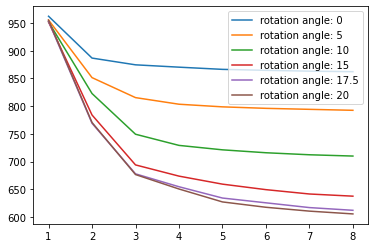

In [6]:
# Model selection - choose best angle and best L

# first, find rotation angle that looks best. Below it is 20.
plot_angle_selection(losses,rotation_angle_list=rotation_angle_list)

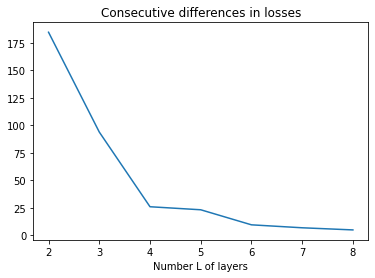

In [7]:
# Then, using that rotation angle, plot consecutive differences and choose approximate elbow
# Below, we select L=6

best_angle=20
plot_consecutive_diffs(losses, best_angle,rotation_angle_list=rotation_angle_list)

Step 5: get labels from Belayer

<function rotate_by_theta at 0x7fcfcf977c10>


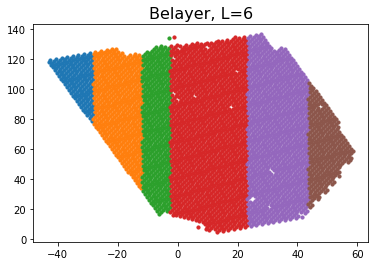

In [8]:
# Finally, plot the labels from Belayer

best_L=6
belayer_labels=belayer_output(labels, coords, best_L, best_angle,rotation_angle_list=rotation_angle_list)

TODOTODOTODO Step 6: Spatially varying gene analysis

## TODOTODOTODO: add SVG analysis

# Tutorial for skin wound

Step 1: load data

In [3]:
input_10x_folder='/n/fs/ragr-data/users/congma/Codes/spatial_embedding/data/SkinWoundPNAS/Visium/V19N18-025_A1/outs/'
count, coords, barcodes, genes=read_input_10xdirectory(input_10x_folder)

G,N=count.shape

# fill in gaps in 10x hexagonal grid
fullpoints, in_tissue = fill_geometry(coords, is_hexagon=True)

# get boundary points
boundary_file='/n/fs/ragr-data/users/congma/Codes/belayer-development/reproducibility/skin_wound/list_boundaries.npy'
boundary_list = read_boundary_list(boundary_file, fullpoints)



Step 2: run/load GLMPCA

In [5]:
# OPTION 1: generate GLM-PCA and save to file
# glmpca_res = glmpca.glmpca(count, 2*3, fam="poi", penalty=10, verbose=True)
# F_glmpca = glmpca_res['factors']
# np.save('INSERT/PATH/', F_glmpca)

# OPTION 2: load pre-computed GLM-PCs
F_glmpca=np.load(input_10x_folder+'glmpca_6PC_10.npy')

Step 2: run harmonic interpolation for each pair of consecutive boundaries

In [6]:
# harmonic interpolation
spos = spatialcoord(x = fullpoints[:,0], y = fullpoints[:,1])
har = harmonic(fullpoints, spos.adjacency_mat, np.sqrt(spos.pairwise_squared_dist))
interpolation = har.interpolation_using_list( boundary_list )
interpolated_coords = interpolation[in_tissue]

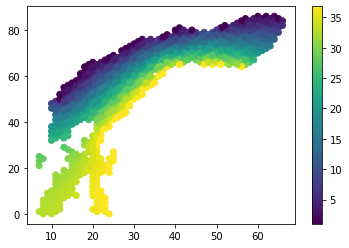

In [7]:
plt.scatter(coords[:,0],coords[:,1],c=interpolated_coords)
plt.colorbar()

Step 3: run DP and get segments

In [12]:
# try my DP code...

L=3
error_mat, segment_map = dp_raw(F_glmpca.T, L, interpolated_coords)

Step 4: get segments from DP and plot labels

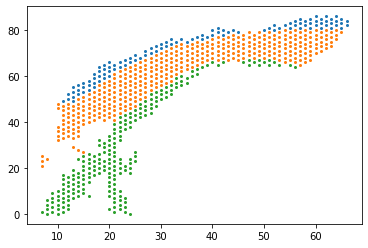

In [19]:
# same as above with my DP
segs = find_segments_from_dp(error_mat, segment_map, L,xcoords=interpolated_coords)
dp_labels = np.zeros(N, dtype=int)
c=0
for seg in segs:
    dp_labels[ seg ] = c
    c+=1

for t in np.unique(dp_labels):
    pts_t=np.where(dp_labels==t)
    plt.scatter(coords[pts_t,0],coords[pts_t,1],s=4)


In [ ]:

# output labels
df_dp_labels = pd.DataFrame({"depth":interpolation, "layer":dp_labels}, index=barcodes)
df_dp_labels.to_csv(args.outprefix + "_layers.txt", sep="\t")
# fitting expression function per gene
selected_genes = select_commonly_expressed_genes(count, interpolation, q=0.75)
totalumi = np.sum(count, axis=0)
df_gene_func = segmented_poisson_regression(count[selected_genes,:], totalumi, dp_labels, interpolation)
df_gene_func.index = genes[selected_genes]
# output per-gene regression parameter
df_gene_func.to_csv(args.outprefix + "_function_coefficients.txt", sep="\t")